# Mathematical Engineering - Financial Engineering, FY 2024-2025
# Risk Management - Exercise 4: Credit Portfolio Single Factor Model

In [1]:
# Importing the libraries
import os
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import datetime as dt
from typing import Iterable, Union, List, Tuple
from scipy.stats import norm,stats
import matplotlib.pyplot as plt

from bootstrap import bootstrap
from ex1_utilities import (
    business_date_offset,
    get_discount_factor_by_zero_rates_linear_interp,
)

from utilities import read_mat_file_dates
from utilities import read_mat_file_rates
from utilities import convert_date_to_string



In [2]:
# !!! READ MARKET AND BOOTSTRAP DATA !!!
datesSet = read_mat_file_dates("datesSet.mat")
datesSetNew = {"settlement":convert_date_to_string(datesSet["settlement"]), "depos": convert_date_to_string(datesSet["depos"]),
               "futures_settlement": convert_date_to_string(datesSet["futures_settlement"]), "futures_expiry": convert_date_to_string(datesSet["futures_scadenza"]),
               "swaps": convert_date_to_string(datesSet["swaps"])}
ratesSet = read_mat_file_rates("ratesSet.mat")
[dates, discounts] = bootstrap(datesSetNew,ratesSet)
discounts = [1] +  discounts
dates = datesSetNew["settlement"] + dates
dates = [dt.datetime.strptime(date, "%Y-%m-%d") for date in dates]
today = dates[0]
discount_factors = discounts
discount_factors=pd.Series(discount_factors, index=dates)

In [3]:
# Parameters
issuers_num = 100  # Number of bonds in the portfolio
maturity = 2  # Maturity in years

rating = "IG"  # Credit rating

expiry = business_date_offset(today, year_offset=maturity)
transition_matrix = pd.DataFrame(
    [[0.73, 0.25, 0.02], [0.35, 0.6, 0.05], [0, 0, 1]],
    index=["IG", "HY", "Def"],
    columns=["IG", "HY", "Def"],
)

recovery_rate = 0.4
face_value = 1_000_000
rho = 0
mc_simulations = 1_000_000
alpha=99

In [10]:
# Q1-Q3: Portfolio MtM Evaluate the present value in a years' time under various scenarios
df_expiry = get_discount_factor_by_zero_rates_linear_interp(
    today, expiry, discount_factors.index, discount_factors.values
)
df_1y=get_discount_factor_by_zero_rates_linear_interp(
    today,
    business_date_offset(today, year_offset=1),
    discount_factors.index,
    discount_factors.values
)
# We consider the default at the midpoint
df_1y_def = get_discount_factor_by_zero_rates_linear_interp(
    today,
    business_date_offset(today, month_offset=6),
    discount_factors.index,
    discount_factors.values
)
df_2y_def = get_discount_factor_by_zero_rates_linear_interp(
    today,
    business_date_offset(today, month_offset=18),
    discount_factors.index,
    discount_factors.values
)
survival_prob_1y = transition_matrix.loc["IG", "IG"] + transition_matrix.loc["IG", "HY"]  
survival_prob_2y =(
    transition_matrix.loc["IG", "IG"] * (transition_matrix.loc["IG", "IG"] + transition_matrix.loc["IG", "HY"]) +
    transition_matrix.loc["IG", "HY"] * (transition_matrix.loc["HY", "IG"] + transition_matrix.loc["HY", "HY"])
)
fwd_price_ig =face_value*((1-transition_matrix.loc["IG", "Def"])*df_expiry+transition_matrix.loc["IG", "Def"]*recovery_rate*df_2y_def)/df_1y
fwd_price_hy =face_value*((1-transition_matrix.loc["HY", "Def"])*df_expiry+transition_matrix.loc["HY", "Def"]*recovery_rate*df_2y_def)/df_1y
print(fwd_price_ig)
print(fwd_price_hy)
bond_mtm=(transition_matrix.loc["IG", "IG"]*df_1y*fwd_price_ig+transition_matrix.loc["IG", "HY"]*df_1y*fwd_price_hy+transition_matrix.loc["IG", "Def"]*recovery_rate*face_value*df_1y_def)
ptf_mtm = bond_mtm*issuers_num
print(ptf_mtm)

[958106.69401366]
[940823.26942569]
[91288211.35318315]


In [5]:
# Q4: Monte Carlo simulation
# Barriers and PnL for a single IG issuer*
barrier_default =norm.ppf(transition_matrix.loc["IG", "Def"])
barrier_downgrade = norm.ppf(transition_matrix.loc["IG", "Def"]+transition_matrix.loc["IG", "HY"])
barrier_upgrade = np.inf  # It can't be upgraded
#def_factor= recovery_rate*transition_matrix.loc["IG", "Def"]*df_2y_def
loss_given_default =(bond_mtm/df_1y-face_value*recovery_rate/df_1y)
loss_given_downgrade = (bond_mtm/df_1y-fwd_price_hy)
loss_status_quo = (bond_mtm/df_1y-fwd_price_ig)
loss_upgrade = 0 # It can't be upgraded
print(loss_given_default)
print(loss_given_downgrade) 
print(loss_status_quo)
print(type(mc_simulations),
    type(issuers_num),
    type(rho),
    type(barrier_default),
    type(barrier_downgrade),
    type(loss_given_default),
    type(loss_given_downgrade),
    type(loss_status_quo),
    type(alpha))

[529672.0226566]
[1943.30941197]
[-15340.115176]
<class 'int'> <class 'int'> <class 'int'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'int'>


In [6]:
#Q4-Q6
def VAR_ES(
    mc_simulations: int,
    issuers_num: int,
    rho: float,
    barrier_default: float,
    barrier_downgrade: float,
    loss_given_default: float,
    loss_given_downgrade: float,
    loss_status_quo: float,
    alpha: int,
    defaults_only: bool = False,
) -> Tuple[float, float]:
    """Returns the VaR and the expected loss"""
    print("rho=",rho)
    np.random.seed(69)
    y = np.random.normal(size=(mc_simulations, 1))
    z = np.random.normal(size=(mc_simulations, issuers_num))
    # Adding correlation
    v =np.sqrt(rho)*y+np.sqrt(1-rho)*z

    #Binary variables
    defaults = sum(v<barrier_default)  # Default per issuer
    downgrades = sum((v<barrier_downgrade) & (v>=barrier_default)) # Downgrade per issuer
    status_quo =len(np.ones(mc_simulations))-downgrades-defaults  # Status quo per issuer
    defaults_sim = np.sum(v<barrier_default,axis=1)  # Default per simulation
    downgrades_sim = np.sum((v<barrier_downgrade) & (v>=barrier_default),axis=1) # Downgrade per simulation
    status_quo_sim =len(np.ones(issuers_num))-downgrades_sim-defaults_sim # Status quo per simulation
    upgrades = np.zeros(len(v))  # No upgrade
    
    print(f"Average defaults: {defaults.mean()}")
    print(f"Average downgrades: {downgrades.mean()}")
    print(f"Average status quo: {status_quo.mean()}")
    # Marginal distributions (check)
    prob_default = defaults.mean() / mc_simulations
    prob_downgrade = downgrades.mean() / mc_simulations
    prob_status_quo = status_quo.mean() / mc_simulations
    prob_upgrades = upgrades.mean() / mc_simulations
    print(f"Probability of default: {prob_default}")
    print(f"Probability of downgrade: {prob_downgrade}")  
    print(f"Probability of status quo: {prob_status_quo}")
    print(f"Probability of upgrade: {prob_upgrades}")    

    # Evaluating the one-year alpha% VaR by taking into account defaults only/defaults and downgrades

    # Here one should consider also the  impact of the status quo
    if defaults_only:
        print("Defaults only")
        scenario = defaults_sim*loss_given_default+(status_quo_sim+downgrades_sim)*loss_status_quo #the
    else:
        print("Defaults + Downgrades")
        scenario = defaults_sim*loss_given_default + downgrades_sim*loss_given_downgrade + status_quo_sim*loss_status_quo 

    sorted_scenario = np.sort(scenario)
    VaR = np.percentile(scenario, alpha)
    expected_loss = np.mean(scenario[scenario > VaR]) 

    print(f"Expected loss: {expected_loss:,.2f}€")
    print(f"VaR: {VaR:,.2f}€\n") 
    
    plt.figure()
    plt.plot(sorted(scenario))
    plt.title("Tail Scenario")

    plt.figure()
    plt.hist(scenario, bins=250, density=True)
    plt.title("Loss distribution") 
    return VaR,expected_loss



rho= 0.15
Average defaults: 19956.88
Average downgrades: 249917.25
Average status quo: 730125.87
Probability of default: 0.01995688
Probability of downgrade: 0.24991725
Probability of status quo: 0.73012587
Probability of upgrade: 0.0
Defaults only
Expected loss: 7,103,212.87€
VaR: 5,006,134.14€

rho= 0.15
Average defaults: 19956.88
Average downgrades: 249917.25
Average status quo: 730125.87
Probability of default: 0.01995688
Probability of downgrade: 0.24991725
Probability of status quo: 0.73012587
Probability of upgrade: 0.0
Defaults + Downgrades
Expected loss: 7,620,769.48€
VaR: 5,818,455.09€

rho= 0.0
Average defaults: 19977.38
Average downgrades: 249980.49
Average status quo: 730042.13
Probability of default: 0.01997738
Probability of downgrade: 0.24998049
Probability of status quo: 0.73004213
Probability of upgrade: 0.0
Defaults only
Expected loss: 2,435,354.62€
VaR: 1,736,061.31€

rho= 0.0
Average defaults: 19977.38
Average downgrades: 249980.49
Average status quo: 730042.13
Pro

(9468763.259956675, 13288482.578118995)

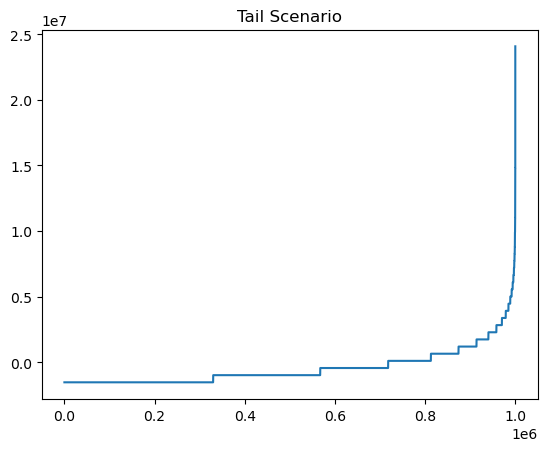

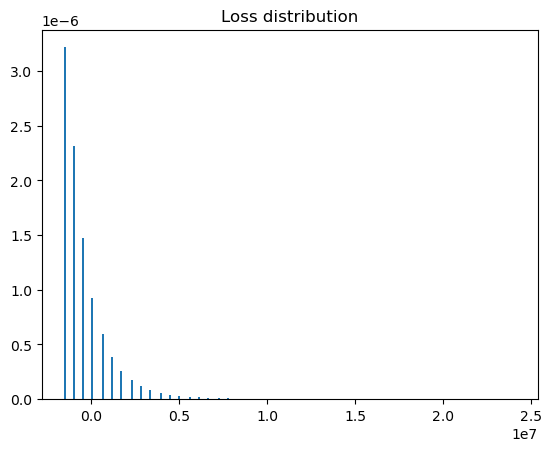

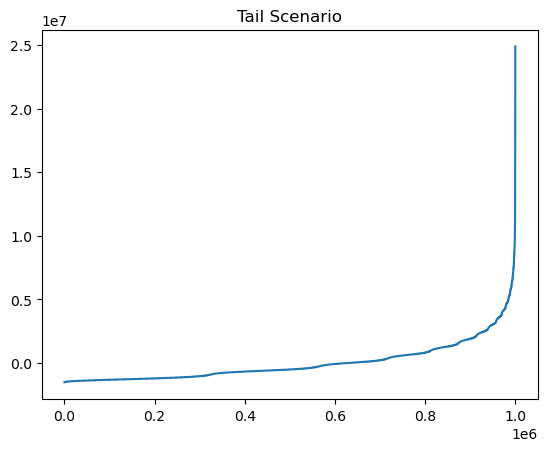

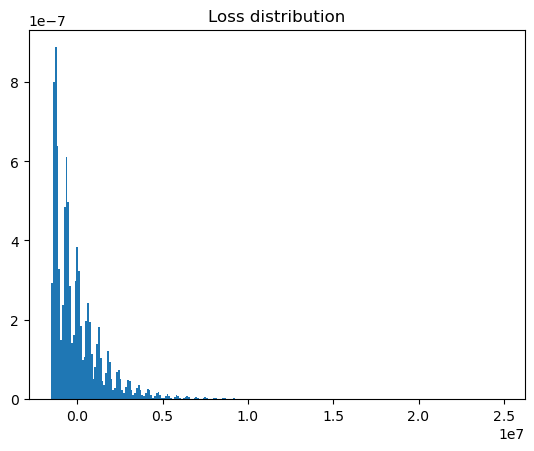

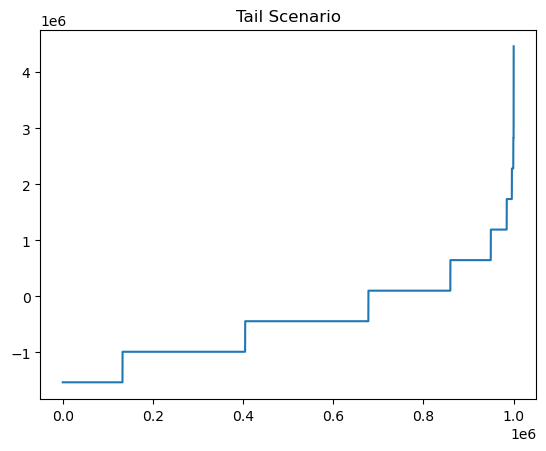

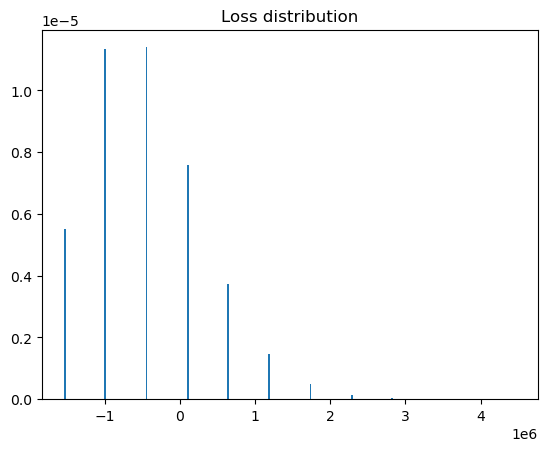

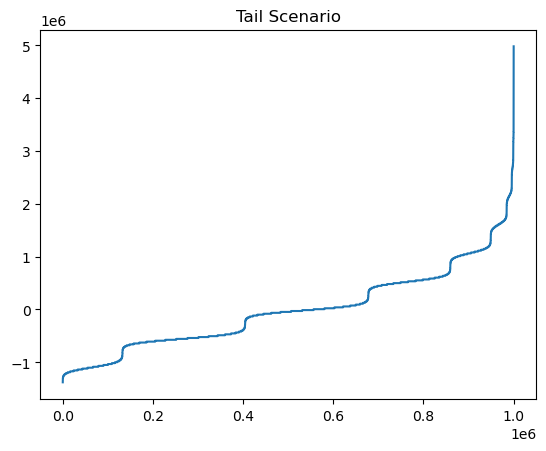

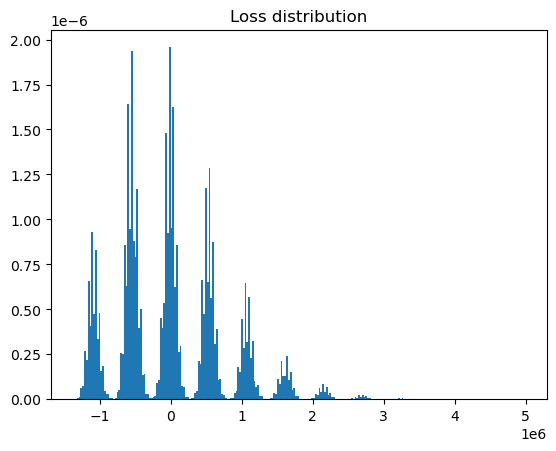

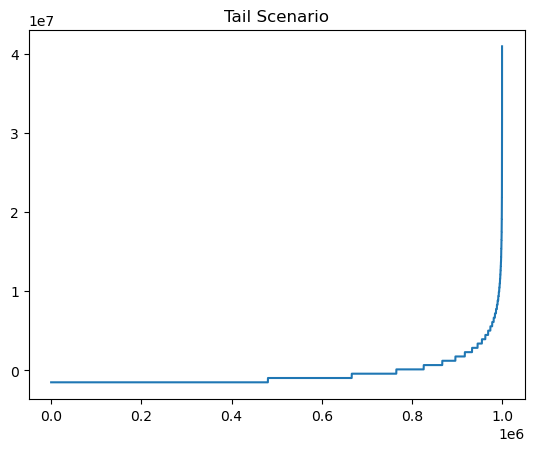

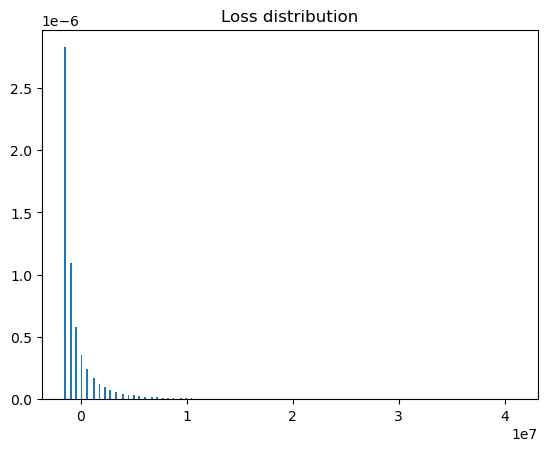

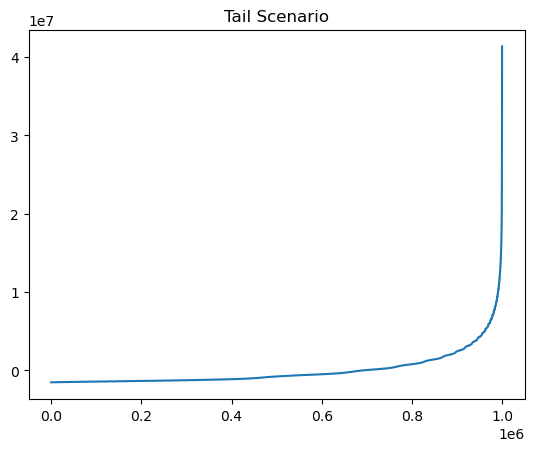

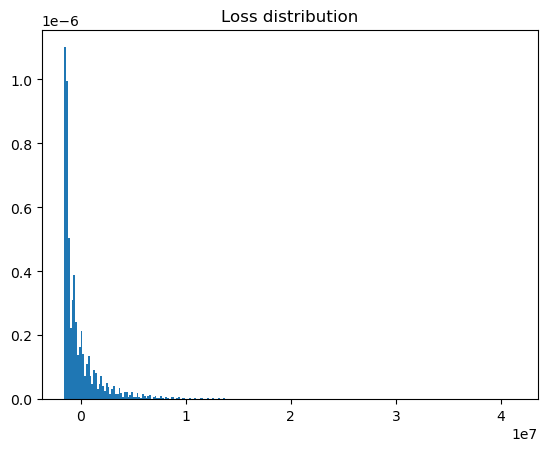

In [7]:
VAR_ES(mc_simulations,issuers_num,0.15,barrier_default,barrier_downgrade,
       loss_given_default,loss_given_downgrade,loss_status_quo,alpha,defaults_only=True) #Defaults only, rho=0.15
VAR_ES(mc_simulations,issuers_num,0.15,barrier_default,barrier_downgrade,
       loss_given_default,loss_given_downgrade,loss_status_quo,alpha) #Defaults+Downgrades, rho=0.15
VAR_ES(mc_simulations,issuers_num,0.00,barrier_default,barrier_downgrade,
       loss_given_default,loss_given_downgrade,loss_status_quo,alpha,defaults_only=True) #Defaults only, rho=0.00
VAR_ES(mc_simulations,issuers_num,0.00,barrier_default,barrier_downgrade,
       loss_given_default,loss_given_downgrade,loss_status_quo,alpha)#Defaults+Downgrades, rho=0.00
VAR_ES(mc_simulations,issuers_num,0.30,barrier_default,barrier_downgrade,
       loss_given_default,loss_given_downgrade,loss_status_quo,alpha,defaults_only=True) #Defaults only, rho=0.30
VAR_ES(mc_simulations,issuers_num,0.30,barrier_default,barrier_downgrade,
       loss_given_default,loss_given_downgrade,loss_status_quo,alpha)#Defaults+Downgrades, rho=0.30

In [8]:
#Q7
new_recovery_rate = 0.1
new_fwd_price_hy =face_value*((1-transition_matrix.loc["HY", "Def"])*df_expiry/df_1y+transition_matrix.loc["HY", "Def"]*new_recovery_rate*df_2y_def/df_1y) 
new_bond_mtm=(transition_matrix.loc["IG", "IG"]*df_1y*fwd_price_ig+transition_matrix.loc["IG", "HY"]*df_1y*new_fwd_price_hy+transition_matrix.loc["IG", "Def"]*recovery_rate*face_value*df_1y_def)
new_loss_given_default =(new_bond_mtm/df_1y-face_value*recovery_rate/df_1y)
new_loss_given_downgrade = (new_bond_mtm/df_1y-new_fwd_price_hy)
new_loss_status_quo = (new_bond_mtm/df_1y-fwd_price_ig)

rho= 0.15
Average defaults: 19956.88
Average downgrades: 249917.25
Average status quo: 730125.87
Probability of default: 0.01995688
Probability of downgrade: 0.24991725
Probability of status quo: 0.73012587
Probability of upgrade: 0.0
Defaults only
Expected loss: 6,734,292.72€
VaR: 4,637,213.99€

rho= 0.15
Average defaults: 19956.88
Average downgrades: 249917.25
Average status quo: 730125.87
Probability of default: 0.01995688
Probability of downgrade: 0.24991725
Probability of status quo: 0.73012587
Probability of upgrade: 0.0
Defaults + Downgrades
Expected loss: 8,004,189.17€
VaR: 6,143,104.82€

rho= 0.0
Average defaults: 19977.38
Average downgrades: 249980.49
Average status quo: 730042.13
Probability of default: 0.01997738
Probability of downgrade: 0.24998049
Probability of status quo: 0.73004213
Probability of upgrade: 0.0
Defaults only
Expected loss: 2,066,434.47€
VaR: 1,367,141.16€

rho= 0.0
Average defaults: 19977.38
Average downgrades: 249980.49
Average status quo: 730042.13
Pro

(10053982.258801099, 13775082.4049094)

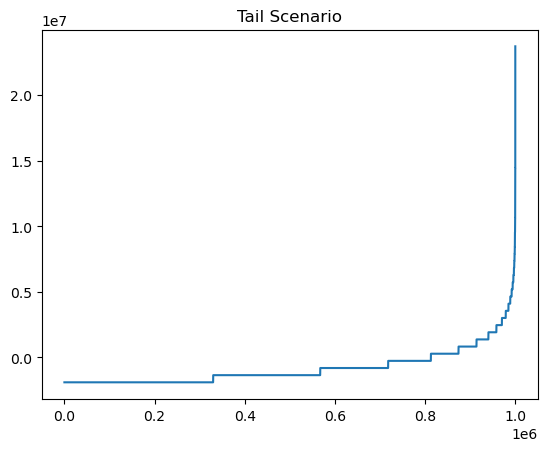

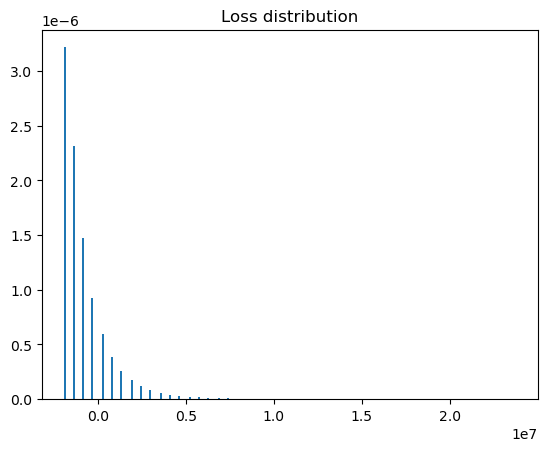

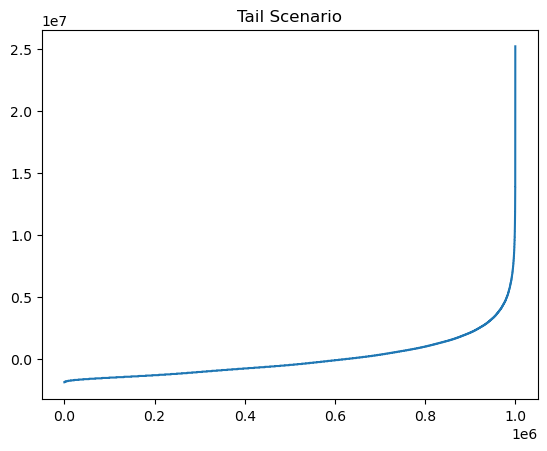

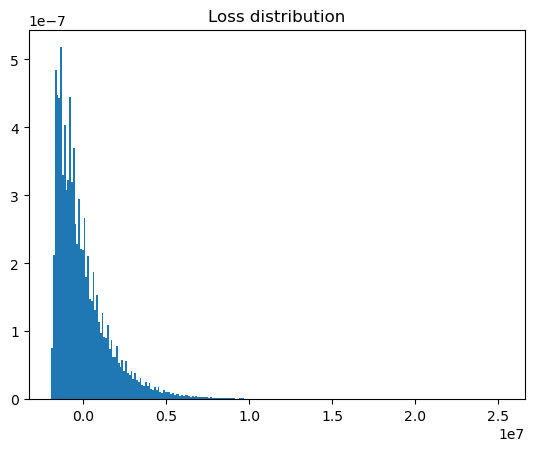

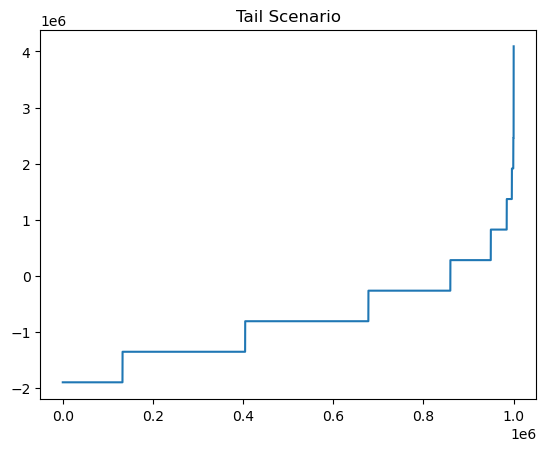

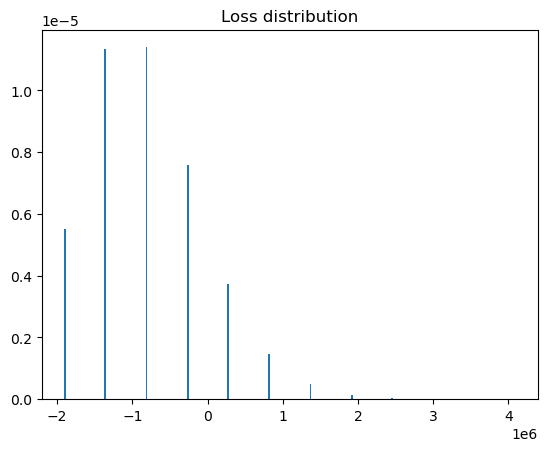

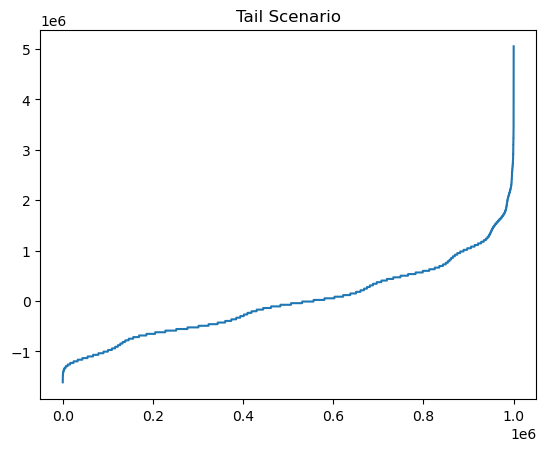

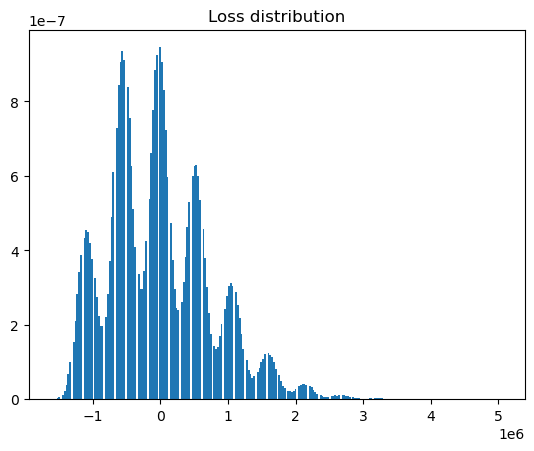

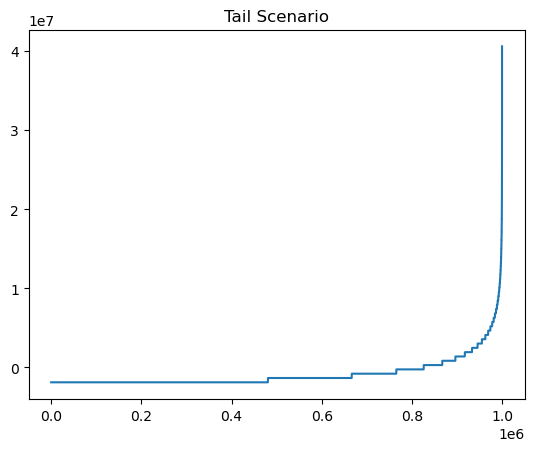

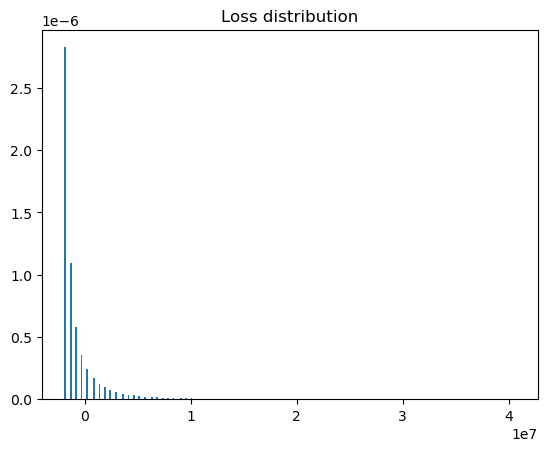

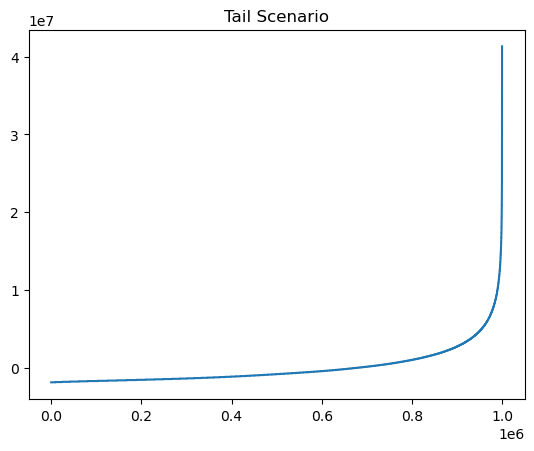

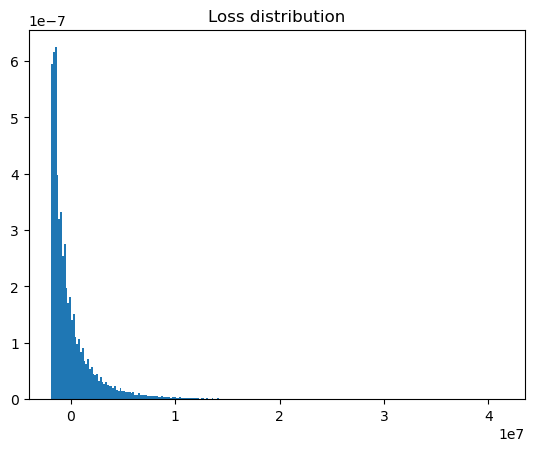

In [9]:
VAR_ES(mc_simulations,issuers_num,0.15,barrier_default,barrier_downgrade,
       new_loss_given_default,new_loss_given_downgrade,new_loss_status_quo,alpha,defaults_only=True) #Defaults only, rho=0.15
VAR_ES(mc_simulations,issuers_num,0.15,barrier_default,barrier_downgrade,
       new_loss_given_default,new_loss_given_downgrade,new_loss_status_quo,alpha) #Defaults+Downgrades, rho=0.15
VAR_ES(mc_simulations,issuers_num,0.00,barrier_default,barrier_downgrade,
       new_loss_given_default,new_loss_given_downgrade,new_loss_status_quo,alpha,defaults_only=True) #Defaults only, rho=0.00
VAR_ES(mc_simulations,issuers_num,0.00,barrier_default,barrier_downgrade,
       new_loss_given_default,new_loss_given_downgrade,new_loss_status_quo,alpha)#Defaults+Downgrades, rho=0.00
VAR_ES(mc_simulations,issuers_num,0.30,barrier_default,barrier_downgrade,
       new_loss_given_default,new_loss_given_downgrade,new_loss_status_quo,alpha,defaults_only=True) #Defaults only, rho=0.30
VAR_ES(mc_simulations,issuers_num,0.30,barrier_default,barrier_downgrade,
       new_loss_given_default,new_loss_given_downgrade,new_loss_status_quo,alpha)#Defaults+Downgrades, rho=0.30